# Color transfer between images

[http://www.numerical-tours.com/matlab/optimaltransp_4_matching_sliced/](http://www.numerical-tours.com/matlab/optimaltransp_4_matching_sliced/)

This method is an application of the theory of optimal transportation introduced by Monge.
Formaly speaking, the aim is to find the optimal transportation cost to transport a distiburion $f$ on a distibution $g$ :

$$MK_c(f,g)=\underset{\pi\in\Pi(f,g)}{inf}\iint_{x,y}c(x,y)d\pi(x,y)$$

In [11]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from scipy.stats import wasserstein_distance
from tqdm import tqdm

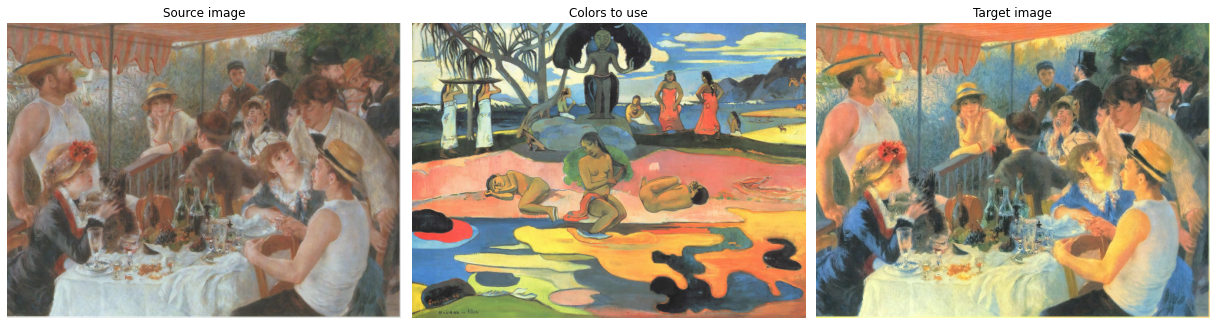

In [12]:
im_src = imread('images/renoir.jpg')
im_color = imread('images/gauguin.jpg')
im_target = imread('images/renoir_by_gauguin_Y.jpg')

fig, ax = plt.subplots(1, 3, figsize=(17,7))
ax[0].imshow(im_src)
ax[0].set_title('Source image')
ax[0].axis('off')
ax[1].imshow(im_color)
ax[1].set_title('Colors to use')
ax[1].axis('off')
ax[2].imshow(im_target)
ax[2].set_title('Target image')
ax[2].axis('off')
plt.tight_layout()
plt.show()

## Wasserstein distance and projection

We consider data (here images) as $f\in\mathbb{R}^{N\times d}$ where $N$ is the number of pixels and $d$ the number of channels (1 for grayscale image, 3 for RGB images).  
$f=(f_i)_{i=1}^N$

### Definition of Wasserstein Distance

We define the distribution in $\mathbb{R}^d$ associated to $f$ (i.e. the histogram of each channel of the image):
$$\mu_f=\frac{1}{N}\sum_{i=1}^N \delta_{f_i}$$
We want to find the permutation $\sigma\in\Sigma_N$ the following sum:
$$\sigma^*\in \underset{\sigma\in\Sigma_N}{argmin} \sum_{i=1}^N\|f_i-g_{\sigma(i)}\|^2$$

$\sigma^*$ is called the optimal assignment and defines the Wasserstein distance:
$$W_2(\mu_f,\mu_g)^2=\sum_{i=1}^N\|f_i-g_{\sigma^*(i)}\|^2=\|f-g\circ\sigma^*\|_2^2$$

Concretely, we re-order the $g$ point cloud to match $f$ distribution the best

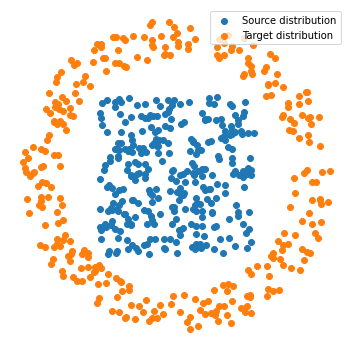

In [3]:
N = 300
d = 2

def normalized_hist(I):
    """
    Computes the normalized histogram of a given image
    """
    N = float(I.shape[0] * I.shape[1])
    hist, edge = np.histogram(I, bins=256, range=[0,256])
    hist = hist.astype(np.float32)/N
    return hist, edge

# define first distribution as 2D points uniformely sampled on a square
dist_1 = np.array([uniform(-1, 1, N), uniform(-1, 1, N)])

# define second distribution sample on a circle
theta = uniform(0, 2 * np.pi, N)
radius = uniform(1.5, 2, N)
dist_2 = radius * np.array([np.cos(theta), np.sin(theta)])

plt.figure(figsize=(5,5))
plt.scatter(dist_1[0], dist_1[1], label='Source distribution')
plt.scatter(dist_2[0], dist_2[1], label='Target distribution')
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
def compute_ortho_basis(d):
    """
    Computes an orthogonal basis or R^d using Gram Schmidt algorithm
    """
    v = np.random.randn(d, d)
    # Gram Schmidt algorithm
    u = np.zeros_like(v)
    u[0] = v[0]
    for i in range(1, d):
        u[i] = v[i]
        for j in range(i):
            u[i] -= (np.dot(v[i],u[j]) / np.dot(u[j], u[j])) * u[j]
    u /= np.linalg.norm(u, axis=1, keepdims=True)
    return u

def optimal_assignment_1D(f, g):
    """
    Determines the optimal 1D assignment (permutation) as defined above
    """
    sigma_f = f.argsort()
    sigma_f_inverse = sigma_f.argsort()
    sigma_g = g.argsort()
    sigma_star = sigma_g[sigma_f_inverse]
    return sigma_star

def P(f, g):
    """
    Computes the orthogonal projection of f on the set \Pi_g(f) as defined above
    """
    sigma_star = optimal_assignment_1D(f, g)
    return g[sigma_star]

def W2(f, g):
    """
    Computes 1D wasserstein distance between distributions f and g
    """
    assert f.shape == g.shape
    return np.linalg.norm(f - P(f,g))

def SW2(f, g):
    """
    Computes the d-dimension sliced wasserstein distance between f and g
    """
    d = f.shape[0]
    thetas = compute_ortho_basis(d) # (d, d)
    dist = 0
    for theta in thetas:
        f_theta = np.dot(theta, f)
        g_theta = np.dot(theta, g)
        dist += W2(f_theta, g_theta)
    return dist

def f_tilde(f, g, thetas):
    """
    f and g of shape (d, N)
    """
    f_theta_star = thetas.T @ f
    g_theta_star = thetas.T @ g
    
    projections = []
    for i in range(len(f)):
        projections.append(P(f_theta_star[i],g_theta_star[i]))
    return thetas @ projections                                                    

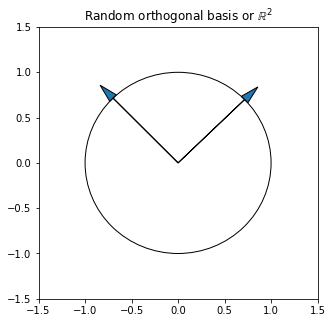

In [5]:
ortho_basis = compute_ortho_basis(2)
plt.figure(figsize=(5,5))
for i in range(len(ortho_basis)):
    plt.arrow(0, 0, ortho_basis[i,0], ortho_basis[i,1], head_width=0.1, head_length=0.2)
circle = plt.Circle((0,0), 1, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title(r'Random orthogonal basis or $\mathbb{R}^{2}$')
plt.show()

## Example on toy dataset

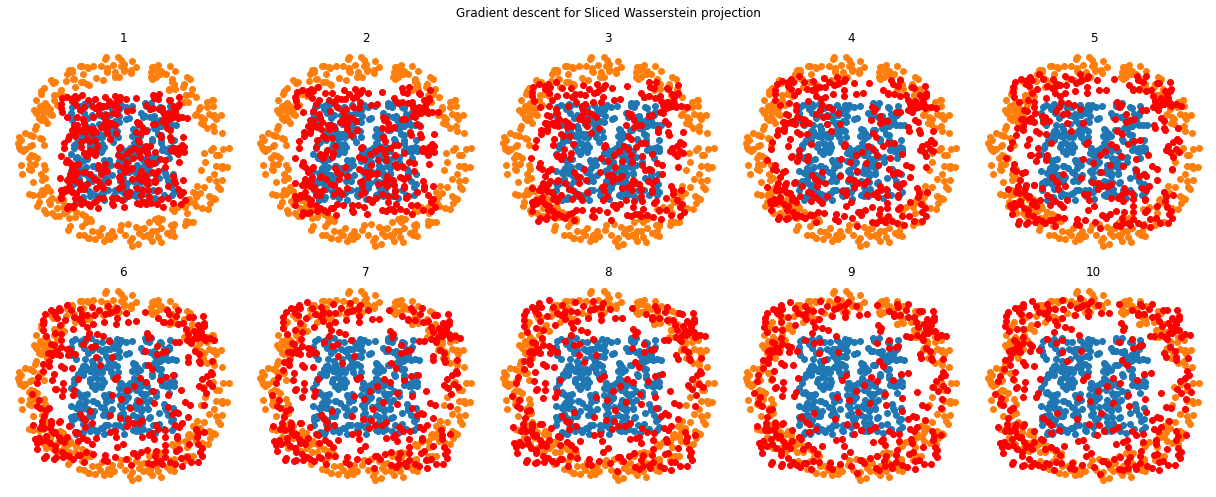

In [6]:
tau = .2
d=2
f = dist_1
g = dist_2


n_iter = 10
f1 = f

fig, axes = plt.subplots(2, 5, figsize=(17,7))
ax = axes.ravel()
plt.suptitle('Gradient descent for Sliced Wasserstein projection')
for i in range(n_iter) :
    thetas = compute_ortho_basis(d)
    f1 = (1-tau)*f1 + tau * f_tilde(f1,g,thetas)
    ax[i].scatter(f[0], f[1])
    ax[i].scatter(g[0], g[1])
    ax[i].scatter(f1[0],f1[1], c='r')
    ax[i].axis('off')
    ax[i].set_title(f'{i+1}')
plt.tight_layout()
plt.show()

## Apply sliced Wasserstein projection on images

In [14]:
r, c, d = im_src.shape
f = im_src.transpose(2,0,1).reshape(d,-1)
g = im_color.transpose(2,0,1).reshape(d,-1)

n_iter = 1_000
f1 = f
tau = .3
for i in tqdm(range(n_iter)) :
    thetas = compute_ortho_basis(d)
    f1 = (1-tau)*f1 + tau * f_tilde(f1,g,thetas)

im_res =  f1.reshape(d,r,c).transpose(1,2,0)
im_res = (im_res - im_res.min()) / (im_res.max()-im_res.min())
imsave('images/renoir_by_gauguin_noisy.png', im_res)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:48<00:00,  1.05it/s]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


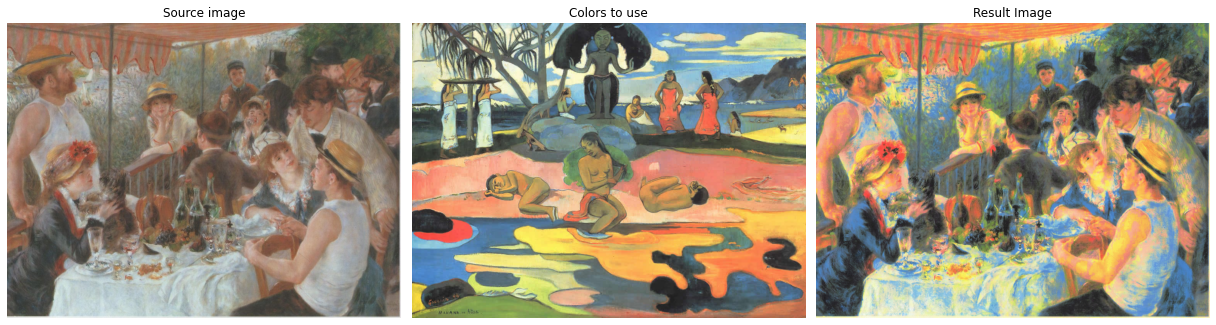

In [16]:
fig, ax = plt.subplots(1,3,figsize=(17,7))
ax[0].imshow(im_src)
ax[0].set_title('Source image')
ax[0].axis('off')
ax[1].imshow(im_color)
ax[1].set_title('Colors to use')
ax[1].axis('off')
ax[2].imshow(im_res)
ax[2].set_title('Result Image')
ax[2].axis('off')
plt.tight_layout()
plt.show()